In [1]:
from qiskit import QuantumCircuit

def deutsh_function(case: int):
    if case not in [1, 2, 3, 4]:
        raise ValueError(" case must be 1, 2, 3 or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

display(deutsh_function(3).draw())

q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘

In [2]:
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n+1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

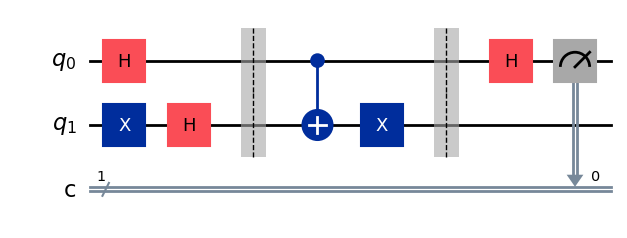

In [3]:
display(compile_circuit(deutsh_function(3)).draw(output="mpl"))

In [4]:
from qiskit_aer import AerSimulator

def deutsh_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots = 1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

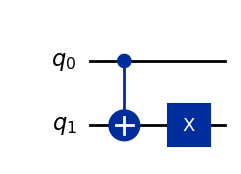

'balanced'

In [5]:
f = deutsh_function(3)
display(f.draw(output="mpl"))
display(deutsh_algorithm(f))

In [6]:
import numpy as np
def dj_function(num_qubits):
    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        return qc

    on_states = np.random.choice(range(2**num_qubits), 2 **num_qubits // 2, replace=False)

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

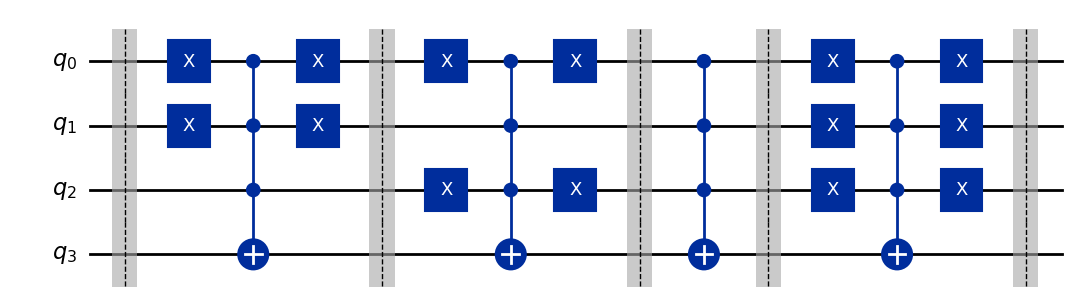

In [7]:
display(dj_function(3).draw(output="mpl"))

In [8]:
def compile_circuit(function : QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.h(range(n+1))
    qc.compose(function, inplace = True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [9]:
def dj_algorithm(function : QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots = 1, memory = True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

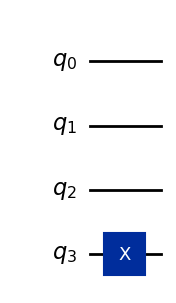

'constant'

In [10]:
f = dj_function(3)
display(f.draw(output="mpl"))
display(dj_algorithm(f))

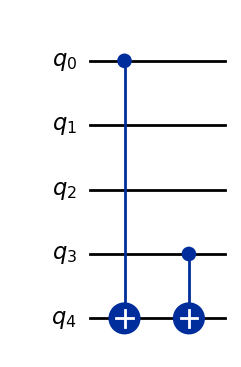

In [11]:
def bv_functions(s):
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_functions("1001").draw(output = "mpl"))

In [12]:
def bv_algorithm(function : QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots = 1, memory=True).result()
    return result.get_memory()[0]

display(bv_algorithm(bv_functions("1001")))

'1001'

In [13]:
import qiskit.quantum_info as qi

def simon_function(s: str):
    n = len(s)
    qc = QuantumCircuit(2 * n)
    pi = np.random.permutation(2**n)

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    qc.unitary(query_gate, range(2 * n))
    return qc

In [14]:
def simon_measurements(problem: QuantumCircuit, k : int):
    n = problem.num_qubits // 2
    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace = True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots = k, memory=True).result()
    return result.get_memory()
    

In [15]:
display(simon_measurements(simon_function("11011"), k=12))

['10101',
 '11000',
 '11111',
 '00000',
 '10010',
 '10010',
 '01101',
 '01101',
 '11100',
 '11111',
 '10001',
 '11111']

In [16]:
import numpy as np
import galois

In [17]:
def simon_algorithm(problem : QuantumCircuit):

    measurements = simon_measurements(problem, k = problem.num_qubits // 2 + 10)
    print("Measurement results:")
    display(measurements)

    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:")
    display(null_space)

    print("Guess for hidden string s :")
    if len(null_space) == 0:
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [18]:
display(simon_measurements(simon_function("10011")))

TypeError: simon_measurements() missing 1 required positional argument: 'k'